# Indexing worldpop
Example notebook how to index a worldpop dataset


In [1]:
import requests
import pandas as pd
from worldex.datasets.worldpop import WorldPopDataset
from pathlib import Path
from h3ronpy.arrow import cells_parse
from h3ronpy.pandas.vector import cells_dataframe_to_geodataframe
import contextily as cx
import json

# Indexing a single country
For this example, we will be indexing the unconstrained population of thailand for 20000

In [2]:
# List possible datasets from worldpop
data = requests.get("https://hub.worldpop.org/rest/data/").json()
pd.DataFrame(data["data"])

,alias,name,title,desc
0,pop,Population Counts,Population Counts,<b>WorldPop produces different types of gridde...
1,births,Births,Births,The health and survival of women and their new...
2,pregnancies,Pregnancies,Pregnancies,The health and survival of women and their new...
3,urban_change,Urban change,Urban change,East–Southeast Asia is currently one of the fa...
4,age_structures,Age and sex structures,Age and sex structures,<b>WorldPop produces different types of gridde...
5,dahi,Development Indicators,Development and Health Indicators,Improved understanding of geographical variati...
6,dependency_ratios,Dependency Ratios,Dependency Ratios,The age group composition of populations varie...
7,internal_migration_f,Migration Flows,Migration Flows,Human mobility continues to increase in terms ...
8,dynamic_mapping,Dynamic Mapping,Dynamic Mapping,Knowing where people are is critical for accur...
9,global_flight_data,Global Flight Data,Global Flight Data,The expanding global air network provides rapi...


In [3]:
# List possible groups for population
data = requests.get("https://hub.worldpop.org/rest/data/pop").json()
pd.DataFrame(data["data"])

,alias,name
0,pic,Individual countries
1,pop_continent,Whole Continent
2,wpgp,Unconstrained individual countries 2000-2020 (...
3,wpgp1km,Unconstrained global mosaics 2000-2020 ( 1km r...
4,,WP00643
5,wpgpunadj,Unconstrained individual countries 2000-2020 U...
6,wpic1km,Unconstrained individual countries 2000-2020 ...
7,wpicuadj1km,Unconstrained individual countries 2000-2020 U...
8,cic2020_100m,Constrained Individual countries 2020 ( 100m r...
9,cic2020_UNadj_100m,Constrained Individual countries 2020 UN adjus...


In [4]:
# List countries for population unconstrainted
population = requests.get("https://hub.worldpop.org/rest/data/pop/wpgp").json()
pd.DataFrame(population["data"])

,id,title,popyear,iso3
0,1325,The spatial distribution of population in 2000...,2000,AUS
1,1326,The spatial distribution of population in 2000...,2000,RUS
2,1327,The spatial distribution of population in 2000...,2000,BRA
3,1328,The spatial distribution of population in 2000...,2000,CAN
4,1329,The spatial distribution of population in 2000...,2000,CZE
...,...,...,...,...
5216,6541,The spatial distribution of population in 2020...,2020,ATF
5217,6542,The spatial distribution of population in 2020...,2020,HMD
5218,6543,The spatial distribution of population in 2020...,2020,UMI
5219,6544,The spatial distribution of population in 2020...,2020,SPR


In [5]:
# Index thailand 2000
thailand_2000 = next(
    d for d in population["data"] if d["popyear"] == "2000" and d["iso3"] == "THA"
)
thailand_2000

{'id': '1467',
 'title': 'The spatial distribution of population in 2000, Thailand',
 'popyear': '2000',
 'iso3': 'THA'}

In [6]:
# Create dir to save files
id = thailand_2000["id"]
path = Path(f"../data/worldpop/pop_wggp_{id}")
path.mkdir(parents=True, exist_ok=True)

In [7]:
# Index country
thailand_2000_dataset = WorldPopDataset.from_url(
    f"https://hub.worldpop.org/rest/data/pop/wpgp/?id={id}"
)
thailand_2000_dataset.set_dir(path)
thailand_2000_dataset.index()

,h3_index


In [8]:
with open(path / "metadata.json") as f:
    metadata = json.load(f)

metadata

{'name': 'The spatial distribution of population in 2000, Thailand',
 'source_org': 'WorldPop',
 'last_fetched': '2023-11-06T12:23:41.443852',
 'files': ['https://data.worldpop.org/GIS/Population/Global_2000_2020/2000/THA/tha_ppp_2000.tif'],
 'description': 'Estimated total number of people per grid-cell. The dataset is available to download in Geotiff format at a resolution of 3 arc (approximately 100m at the equator). The projection is Geographic Coordinate System, WGS84. The units are number of people per pixel. The mapping approach is Random Forest-based dasymetric redistribution.',
 'data_format': 'GeoTiff',
 'projection': 'EPSG:4326',
 'properties': {'url_summary': 'https://hub.worldpop.org/geodata/summary?id=1467',
  'category': 'Unconstrained individual countries 2000-2020 ( 100m resolution )'},
 'bbox': 'POLYGON ((105.6387495919999964 5.6162501789999997, 105.6387495919999964 20.4629167860000010, 97.3454162919999959 20.4629167860000010, 97.3454162919999959 5.6162501789999997, 1

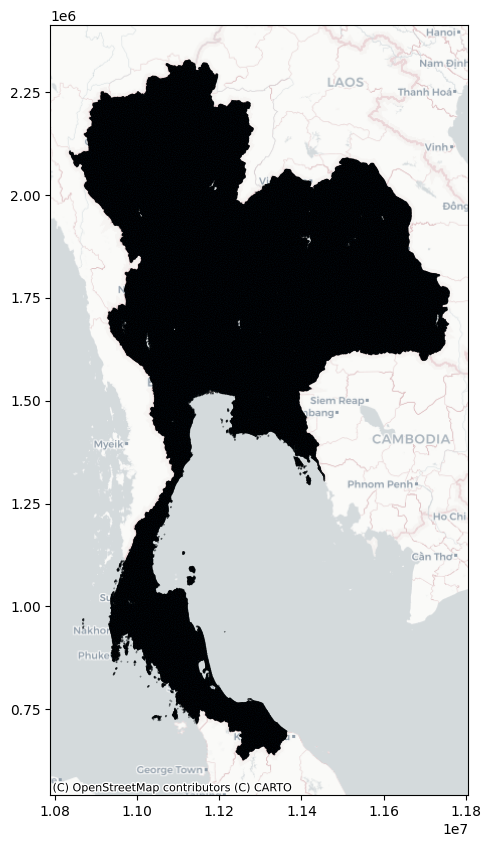

In [9]:
h3 = pd.read_parquet(path / "h3.parquet")

h3_gdf = cells_dataframe_to_geodataframe(
    pd.DataFrame({"cell": cells_parse(h3.h3_index)})
)
h3_gdf_reprojected = h3_gdf.to_crs(epsg=3857)
ax = h3_gdf_reprojected.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Indexing a group of countries
Indexing population for all countries for the year 2000
Note: This is very resource intensive so, we do not suggest running this on a local machine

In [ ]:
datasets_2000 = [
    dataset for dataset in population["data"] if dataset["popyear"] == "2000"
]

In [ ]:
for dataset in datasets_2000:
    id = dataset["id"]
    worldpop = WorldPopDataset.from_url(
        f"https://hub.worldpop.org/rest/data/pop/wpgp/?id={id}"
    )
    path = Path(f"../data/worldpop/pop_wggp_{id}")
    path.mkdir(parents=True, exist_ok=True)
    worldpop.index(path)